# Boston Crime Analysis

## Goals
We're going to be working with a dataset of roughly 270,000 criminal incidents in Boston for three years (March 2012 - Mar 2015). Data is hosted by the <a href=https://data.cityofboston.gov/Public-Safety/Crime-Incident-Reports/7cdf-6fgx>City of Boston</a> and released by the Boston Police Department.

Our goal is to construct a spatiotemporal model of crime rate in Boston, using a model from Professor Dawn Woodward's <a href= https://people.orie.cornell.edu/woodard/ZhouMattWood13.pdf>2015 paper modeling ambulance dispatch calls</a>. We'll construct a nonhomogenous point process model, using Gaussian mixture models to model the spatial distribution (Don't worry if this is foreign to you, we'll break everything down later).


## Outline

### Data Preprocessing
In this step, we'll show how to use command line tools to quickly preprocess your data.

### Exploring Temporal Dynamics
We'll dive deeper into the temporal dynamics of crime incidents, looking for weekly and daily patterns to determine how we should best construct our model.

### Exploring Spatial Dynamics
We'll look at a couple heat maps to check  that there are indeed time varying spatial components to Boston crime data. 

### Notes on Data Science
Why not just use something out of scikit learn?

### Introduction to Poisson Point Processes and Gaussian Mixture Models
Stepping back for a bit from the dataset, we'll talk generally about the type of models we're going to be working with.

### Model Fitting
Using Markov Chain Monte Carlo methods (commonly abbreviated as MCMC methods), we'll construct a time varying Poisson point process to model crime incidents. 

### Evaluation
We'll compare our model with a few simpler ones.

## Data Processing
Let's take a look at our data set to see why this is necessary. The following section should be done in a Bash shell.

We can see that there's a lot of information - let's first examine the NatureCode and Incident_Type_Description fields, looking at all possible values these take on. 

In [8]:
import subprocess
subprocess.call("awk -F ',' '{print $2}' crimedata_nh.csv | sort | uniq -c | sort -nr > keys.csv", shell=True);
data = open('keys.csv').readlines()
print 'Distinct Codes: '+ str(len(data))
print ''.join(data)

Distinct Codes: 320
15999 LARCRT
15932 ARREST
14204 IVPER 
14149 IVPER
12302 MVA
11395 LARCEN
8376 HITRUN
6432 IVMV
6406 IVPREM
6101 BE
6018 VANRPT
5688 BEMVRT
5453 LSTPRP
5106 INVEST
4891 BERPT 
4468 PROP
4275 VAND
3945 THREAT
3906 IVMV  
3805 IVDRUG
3257 AB
3202 MISPER
2922 TSTOP 
2915 MVAINJ
2789 MVA   
2708 DISTRB
2675 MVANO 
2670 LARCIP
2495 ABIP  
2487 FDPROP
2442 ILLPRK
2298 STOLMV
2255 ABRPT 
2017 FIGHT 
1891 EDP2  
1856 UNCONS
1782 MVPED1
1665 TS
1665 NULL
1651 UNK   
1584 BEIP  
1565 HARPT 
1429 REQP  
1403 SSTOP 
1346 ARMROB
1327 INJOFF
1296 EDP
1291 MISC  
1192 CD11  
1162 SHOTS 
1162 FIGHT
1128 PKNIFE
1110 VIORDR
1101 PERGUN
1052 REQP
1024 ROBIP 
 979 CD35  
 944 CARST 
 930 MVBLDR
 894 FIREB 
 890 SS
 884 ALARM
 863 SHPLFT
 862 ROBBER
 860 LANTEN
 843 VANIP 
 762 NIDV
 704 MVPED2
 686 UNKEMS
 680 MISSIN
 674 MISC
 672 SHOTS
 659 MSNCOM
 647 ADMRPT
 640 ROBRPT
 628 CD11
 613 REQEP 
 601 FDWEAP
 598 DVIP  
 581 NIDV  
 580 STAB  
 577 PDRPT 
 545 PARTY 
 541 REMOVE
 509 CD9

A lot of these codes are pretty cryptic and there are a bunch of them. Let's see if the other field describing the crime gives better information.

In [9]:
import subprocess
#just change to the third field
subprocess.call("awk -F ',' '{print $3}' crimedata_nh.csv | sort | uniq -c | sort -nr > keys.csv", shell=True);

print ''.join(open('keys.csv').readlines())

27363 VAL
24443 OTHER LARCENY
17697 SIMPLE ASSAULT
17128 MedAssist
13832 MVAcc
13339 VANDALISM
12937 InvPer
12742 LARCENY FROM MOTOR VEHICLE
12042 DRUG CHARGES
8742 FRAUD
8522 PropLost
7526 TOWED
6737 RESIDENTIAL BURGLARY
6592 InvProp
5649 AGGRAVATED ASSAULT
5353 Service
4974 ROBBERY
4745 PersLoc
4620 AUTO THEFT
4316 PropFound
2833 Argue
1959 Arrest
1902 OTHER
1848 FIRE
1827 DISORDERLY
1525 PhoneCalls
1497 COMMERCIAL BURGLARY
1399 Motor Vehicle Accident Response
1367 BENoProp
1296 FORGERY
1292 LICViol
1288 Larceny
1276 TRESPASS
1191 WEAPONS CHARGE
1139 PersMiss
1123 PubDrink
1009 Gather
1001 Landlord
 937 DEATH INVESTIGATION
 915 32GUN
 815 STOLEN PROPERTY CHARGES
 813 Ballist
 800 Investigate Person
 795 SexReg
 737 SearchWarr
 733 Restrain
 731 PropDam
 717 OPERATING UNDER INFLUENCE
 709 Medical Assistance
 697 Other
 689 Hazardous
 637 Simple Assault
 629 Vandalism
 613 07RV
 579 CRIMES AGAINST CHILDREN
 561 Drug Violation
 540 VIOLATION OF LIQUOR LAWS
 523 Larceny From Motor Vehicl

Some of these are pretty obvious. There's no easy way to decipher these, so dig through to see if there's anything related.

Can you figure out what Aircraft is referring to using the grep utility?

Here's an example below.


Here's what I've figured out so far:
<ul>
<li> <b> Aircraft </b>: oddly enough, all the exact same location, even over the span of three years. My guess is it's not an actual crime, but something that gets reported regardless. </li>
<li> <b> InvProp, InvPer, InvVeh </b>: answered by Boston PD on their <a href=https://twitter.com/bostonpolice/status/598911393425956865>twitter</a> and guessed the rest. Investigating property, investigating person, investigating vehicle </li>
<li> <b> Val </b>: answered by Boston PD on their <a href=https://twitter.com/bostonpolice/status/598911393425956865>twitter</a> - violation of auto law (driving w/out proper registration/license) </li>



</ul>

Now that we've figured out what all of these mean, we can start doing basic analysis.
Let's write a file which will contain all keys, which we'll then modify to include only violent crimes.

In [10]:
crimeValues = dict();
data = open('keys.csv').readlines()
for line in data:
    text = line.strip().split(' ');
    #lower all text
    descrip = ' '.join(text[1:]).lower(); count = int(text[0])
    crimeValues[descrip] = count;
# write to csv file
keys = sorted(crimeValues.keys())
f = open('crimeskey.csv', 'wb');
for key in keys:
    f.write(key +','+str(crimeValues[key])+',\n')
    


After renaming the file (to avoid accidentally overwriting our mapping), we can reload the file and assemble the dictionary.

In [13]:
data = open('violentcrimeskey.csv').readlines();
crimeMapping = dict();

for line in data:
    stuff = line.strip().split(',')
    crimeMapping[stuff[0]]= int(stuff[2])

#uncomment the block below to print out the dictionary
keys = sorted(crimeMapping.keys())
for key in keys:
    print key + ' '*(27 - len(key)) + str(crimeMapping[key])

07rv                       0
32gun                      1
aggravated assault         1
aircraft                   0
argue                      0
arrest                     0
arson                      1
auto theft                 1
ballist                    1
benoprop                   0
biothreat                  1
bomb                       1
burgtools                  0
commercial burglary        1
crimes against children    1
death investigation        1
disorderly                 1
drug charges               1
embezellment               1
explos                     1
fire                       1
forgery                    1
fraud                      1
gambling offense           1
gather                     0
harass                     1
harbor                     1
hatecrim                   1
hazardous                  1
homicide                   1
invper                     0
invprop                    0
invveh                     0
labor                      0
landlord      

Now let's process the raw data using our mapping, including only crimes we want to consider. This time, we'll create a final file called processed.csv to store all our actual data we want to look at, and to get rid of extraneous fields we no longer need. All we need are the descriptions, the timestamps, day of week, and location.

In [14]:
wbfile = open('processed.csv', 'wb');
with open('crimedata_nh.csv') as file:
    for line in file:
        line = line.split(',');
        if (line[2].lower() in crimeMapping and crimeMapping[line[2].lower()] == 1):
            wline = [line[2].lower(), line[6], line[13], line[19][2:], line [20].strip()[:-3]]
            wbfile.write(','.join(wline)+'\n');
wbfile.close()
        

Great, now we've gotten preprocessing out of the way, we can finally start looking at our data for interesting patterns. Let's write some general tools to help ourselves abstract data collection/parsing and the actual computation

In [39]:
# converts a timestamp to a single time object (instead of Python's datetime)
class Time:
    def __init__(self, stamp):
        stuff = stamp.split(' ');
        date = stuff[0].split('/');
        time = stuff[1].split(':');
        period = stuff[2];
        toAdd = 12 if (period == 'PM') else 0;
        hh = int(time[0]);
        hh = 0 if (hh == 12) else int(time[0]);
        hh+=toAdd;
        mm = int(time[1]); sec = int(time[2]);
        mon = int(date[0]); dd = int(date[1]); yr = int(date[2]);
        self.yr = yr;
        self.dd = dd;
        self.mon = mon;
        self.hh = hh; 
        self.mm = mm;
        self.sec = sec;
        self.monthMap = dict([(0, 0), (1, 31), (2, 59), (3, 90), (4, 120), (5, 151), (6, 181),
                             (7, 212), (8, 243), (9, 273), (10, 304), (11, 334), (12, 365)])
    
    @property
    def secondsSinceDay(self):
        return (self.hh*60 + self.mm)*60+self.sec;
    
    @property #period where 2 hour windows
    def dayPeriod(self):
        return self.hh/2;
    
    @property
    def daysSinceYear(self):
        return self.monthMap[self.mon-1]+self.dd;

'''
Feed is a class that will iterate over the data. 
This will allow us to separate the logic for the details of reading a file/data and the actual computation.

### CALLBACK SIGNATURES ###
def beginCB(void):

def recordCB(data):
     data - dict with keys 'crime' (string), 'timestamp' (Time), 'dow' (int representing day of week)
         'lat' (float), 'long' (float)'

def endCB(void):
'''

class Feed:
    # take in a file name and lists different kinds of call backs
    # EX: Feed('processed.csv', [], [myfunc1, myfunc2], [myfunc3])
    def __init__(self, fname = 'processed.csv', beginCBs = [], recordCBs = [], endCBs = []):
        self._fname = fname;
        self._beginCBs = beginCBs;
        self._recordCBs = recordCBs;
        self._endCBs = endCBs
        self.daymap = dict([('Sunday', 0), ('Monday', 1), ('Tuesday', 2), ('Wednesday', 3), ('Thursday', 4), ('Friday', 5), ('Saturday', 6)])
    
    @property #read only file name once constructed.
    def source(self):
        return self._fname
    
    #run through files, calling appropriate callbacks
    def run(self):
        errCount = 0;
        for cb in self._beginCBs:
            cb();
        with open(self._fname) as file:
            for line in file:
                line = line.split(',');
                #Recall format is crime, timestamp, day, latitude, longitude
                data = dict();
                try:
                    data['lat'] = float(line[-1]);
                    data['long'] = float(line[-2]);
                    data['crime'] = line[0];
                    data['timestamp'] = Time(line[1]); data['dow'] = self.daymap[line[2]]
                    for cb in self._recordCBs:
                        cb(data);
                except:
                    errCount+=1;
        for cb in self._endCBs:
            cb();
        
        print 'Failed to read '+ str(errCount) + ' lines'
    
    # methods for adding callback functions to class
    def addRecordCB(self, cb):
        self._recordCBs.append(cb);
    
    def addBeginCB(self, cb):
        self._beginCBs.append(cb);

    def addEndCB(self, cb):
        self._endCBs.append(cb);       
        

We've written some code to structure our analysis. Let's see how to use it. 

In [40]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#This class will accumulate a list of times during a week 
class TimeSeriesCollect: 
    def __init__(self, crime):
        self.data = []
        self.prevperiod = 0;
        self.crime = crime
    
    def recordCB(self, data):
        if (data['crime'] == self.crime):
            self.data.append(data['timestamp'].secondsSinceDay + data['dow']*24*60*60);

    ''' 
    Once we've collected the data, we get to actually do some interesting computation now.
    Let's bin into 10 minute windows to generate a time series, then plot this result.
    '''
    def endCB(self):
        npdata = np.array(self.data);
        npdata = npdata/60*60;
        ax = plt.axes([0, 1, 2, 0.5]);
        #I want 10 minute windows - this is 6*24*7 bins (weekly)
        ax.hist(npdata, 6*24*7, normed=1, facecolor='blue', alpha=0.75, edgecolor='none')
        plt.title(self.crime);
        

Here's how to use the class.

Our model of crime data is going to use time as a variable, but at most we're going to take time of week into account (i.e. not differentiate between day of the year since we don't have that much data). But it's worth checking if we even need to go into this much level - does day of the week even impact when crimes occur significantly? Or can we get by just considering time of day. This would certainly simplify our analysis.

Failed to read 0 lines


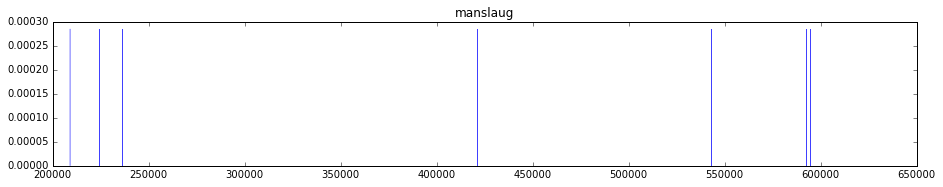

In [41]:
collect = TimeSeriesCollect('manslaug');
f = Feed('processed.csv', [], [lambda data: collect.recordCB(data)], [lambda : collect.endCB()]);
f.run()

Let's take a look at assault - it seems likely that weekend nights would have higher incidence rates.

Failed to read 0 lines


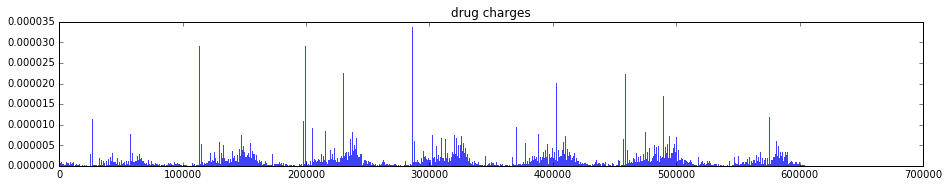

In [42]:
def plotTSeries(crime):
    collect = TimeSeriesCollect(crime);
    f = Feed('processed.csv', [], [lambda data: collect.recordCB(data)], [lambda : collect.endCB()]);
    f.run()

#I only looked at crimes with a large number of incidents
plotTSeries('drug charges');

Failed to read 0 lines


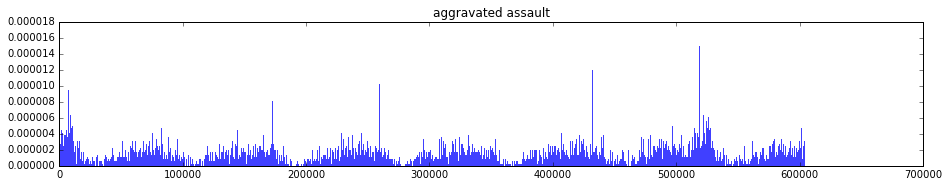

In [43]:
plotTSeries('aggravated assault')

It looks like day of week does matter from a first glance - but let's do some more analysis. I found <a href="http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4.htm">this resource</a> to be a good option for an introduction to time series analysis for someone with minimal statistics background.

Let's first do some spatial analysis and some scatter plots before diving deeper into temporal dynamics.

In [65]:
import math

#This class will accumulate a list of times during a week of an occurence of a crime.
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#This class will accumulate a spatial distribution of a crime of times during a week 
class SpatialDistributionCollect: 
    def __init__(self, crime = 'all'):
        self.data = dict();
        self.crime = crime;
        for i in range(84):
            self.data[i] = [];
    
    def recordCB(self, data):
        if (data['crime'] == self.crime or self.crime == 'all'):
            period =  data['timestamp'].dayPeriod + data['dow']*12;
            if (data['lat'] < -2 and data['long'] > 2):
                self.data[period].append([data['lat'], data['long']])

    ''' 
    '''
    def endCB(self):
        fig = plt.figure(figsize=(4, 28));
        plt.title(self.crime);
        for i in range(20):
            self.data[i] = np.array(self.data[i])
            ax = fig.add_subplot(20, 1, i+1);
            data = self.data[i*2];
            ax.scatter(self.data[i][:, 0], self.data[i][:, 1], alpha=0.5, color='blue');

We have some preliminary analysis that shows the strongest intraweekly variation occurs for aggravated and simple assault.

In [66]:
def getSpatial(crime):
    collect = SpatialDistributionCollect(crime);
    f = Feed('processed.csv', [], [lambda data: collect.recordCB(data)], [lambda : collect.endCB()]);
    f.run()
    return collect;

Failed to read 0 lines


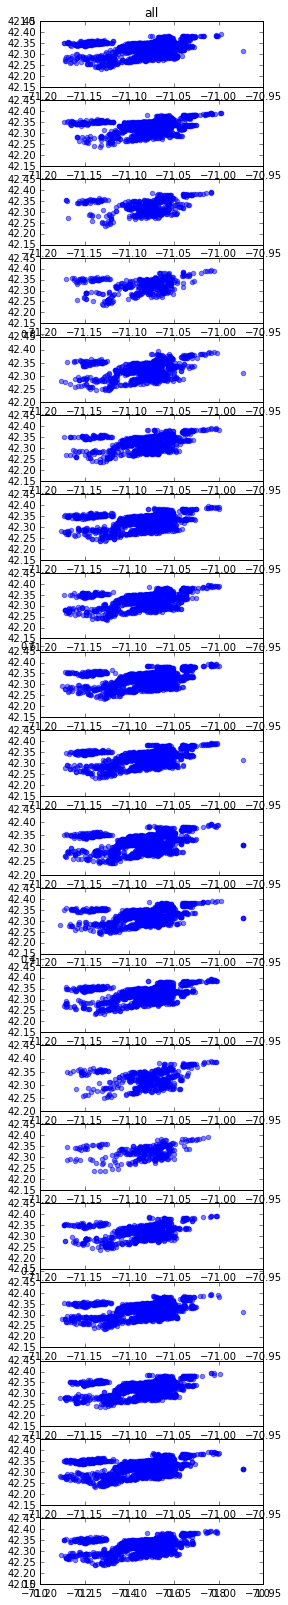

In [68]:
violentCrime = getSpatial('all');

# Notes on Data Science
Let's back up for a little bit. We've now explored our data quite a bit, finding strong evidence of a temporal component to crime rate and some (though admittedly not much) evidence of a time varying spatial distribution.

Why am I walking you through a complicated model? Can't neural networks can learn everything??

It's worth taking some time to comment on the recent obsession with neural networks, in particular their application to finance.
<ul>
    <li> Viewing neural networks as a pseudo brain is a bad way to view them - what are they really doing? </li>
    <li> Are they really helpful for applications to quantiative finance and HFT? </li>
</ul>
   

Here are some tips for modeling data well:
<ul>
    <li> Always try and use something about the problem structure. What does this mean? </li>
    <li> What are some important features about this dataset we can use? What are some valid assumptions? </li>
    <li> Crime rates should vary smoothly with respect to time and space, Actual crime incidents are somewhat random, meaning the fact that a crime occurs at 11:11 pm does not necessarily mean it will occur in the future and we should model crime as stemming from an underlying process.</li>
</ul>

## Gaussian Mixture Models
Here we model a distribution by taking multiple Gaussians and adding them to get a simplified representation.
See the following link for a <a href= "https://www.ll.mit.edu/mission/cybersec/publications/publication-files/full_papers/0802_Reynolds_Biometrics-GMM.pdf">paper</a> with more detail.
This is what we're using to model the spatial distribution.


## Point Processes
### Poisson Point Processes
A generative model for occurrence of spatial events. 
We select a number of points according to a Poisson distribution and place each one uniformly at random.

### Inhomogeneous Point Process
This is what we're interested in - it allows us to capture the time varying spatial distribution generating the dataset.